In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [4]:
######## 读取数据 ########
sheet = pd.read_excel('data_input/美国天然气HH连1合约.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
sheet.tail()

,Date,美国天然气HH连1合约Trend/F0.1,美国天然气HH连1合约
3477,2025-11-03,3.262960,4.266
3478,2025-11-04,3.261814,4.343
3479,2025-11-05,3.260661,4.232
3480,2025-11-06,3.259501,4.357
3481,2025-11-07,3.258336,4.315


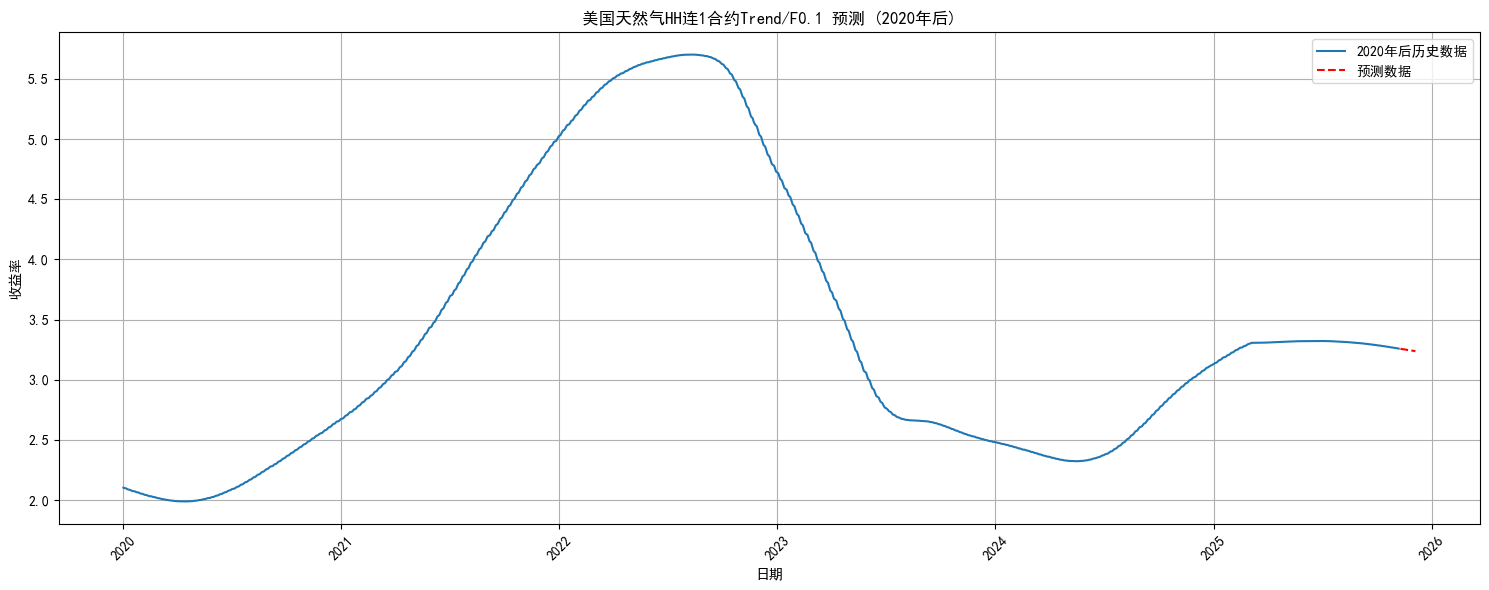

In [5]:
sheet = sheet.dropna()
# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])
# 生成未来30个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')  # 生成45天以确保获得30个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:20]  # 只保留工作日并取前30天

# 获取最后30个历史值用于线性回归
last_values = sheet['美国天然气HH连1合约Trend/F0.1'].tail(20).values
x = np.arange(len(last_values))
y = last_values

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 预测未来30个值
future_x = np.arange(len(last_values), len(last_values) + 20)
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '美国天然气HH连1合约Trend/F0.1': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)


# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['美国天然气HH连1合约Trend/F0.1'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['美国天然气HH连1合约Trend/F0.1'], 'r--', label='预测数据')
plt.title('美国天然气HH连1合约Trend/F0.1 预测 (2020年后)')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/美国天然气HH连1合约Non-Trend_F0.1_合并数据.xlsx', sheet_name='Sheet1')

In [7]:
# 将Date列转换为datetime64[ns]格式
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])

merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '美国天然气HH连1合约Trend/F0.1']], 
    on='Date',
    how='outer'
)
# 删除包含空值的行
merged_df = merged_df.dropna()

# 计算最终的
merged_df['美国天然气HH连1合约'] = 0.6*merged_df['预测值'] + 1.21*merged_df['美国天然气HH连1合约Trend/F0.1']


merged_df.head()

,Date,预测值,美国天然气HH连1合约Trend/F0.1,美国天然气HH连1合约
718,2025-11-10,0.8060,3.257440,4.425102
719,2025-11-11,0.8060,3.256337,4.423768
720,2025-11-12,0.8060,3.255235,4.422434
721,2025-11-13,0.7505,3.254132,4.387800
722,2025-11-14,0.7505,3.253030,4.386466


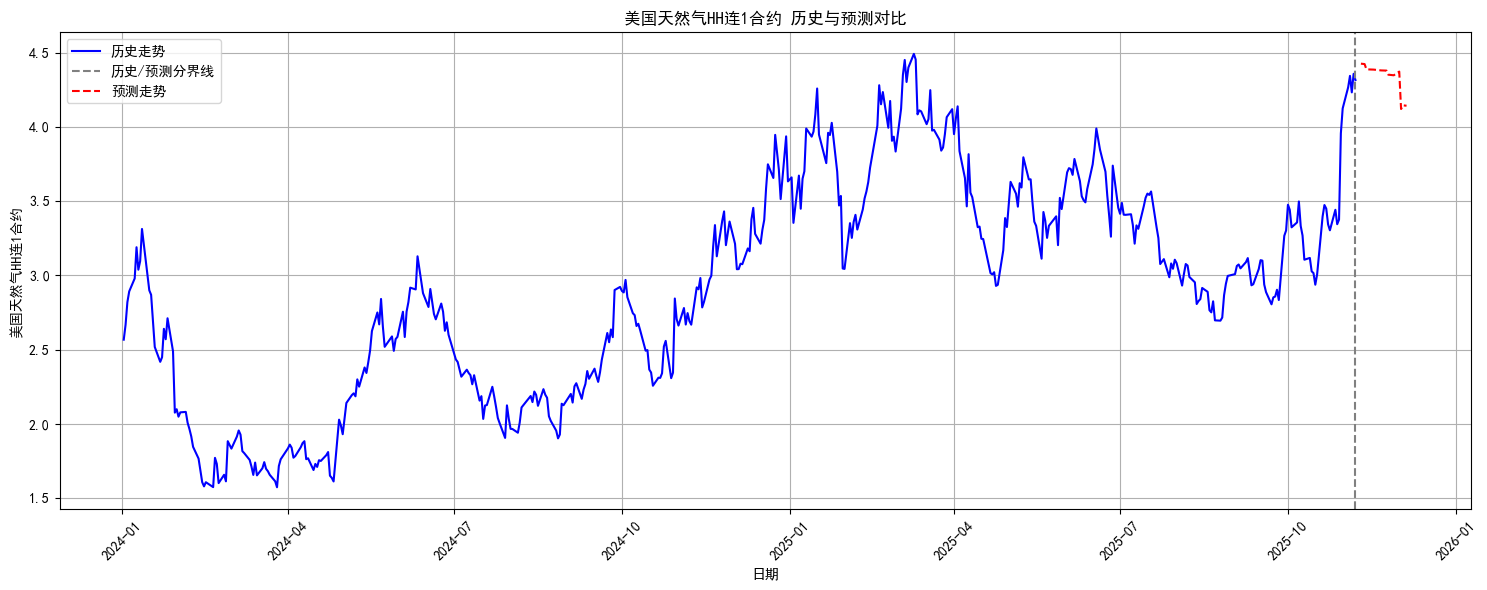

In [8]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))

# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']

# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['美国天然气HH连1合约'], label='历史走势', color='blue')

# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')

# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['美国天然气HH连1合约'], label='预测走势', color='red', linestyle='--')

plt.title('美国天然气HH连1合约 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('美国天然气HH连1合约')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---

In [9]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '美国天然气HH连1合约']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '美国天然气HH连1合约']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/美国天然气HH连1合约_合并数据.xlsx', index=False,float_format='%.2f')


merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
monthly_df_shizhi.to_excel('eta/美国天然气HH连1合约_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head(2)

,Date,实际值,美国天然气HH连1合约
0,2025/12/31,NaN,4.142114
1,2025/11/30,4.315,4.346965


In [10]:
merged_df_shizhi 

,Date,实际值,美国天然气HH连1合约
737,2025-12-05,NaN,4.142114
736,2025-12-04,NaN,4.143448
735,2025-12-03,NaN,4.144782
734,2025-12-02,NaN,4.119956
733,2025-12-01,NaN,4.371790
...,...,...,...
4,2023-01-09,3.910,NaN
3,2023-01-06,3.710,NaN
2,2023-01-05,3.720,NaN
1,2023-01-04,4.172,NaN


---

In [11]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '美国天然气HH连1合约Trend/F0.1']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/美国天然气HH连1合约Trend_F0.1_合并数据.xlsx', index=False,float_format='%.5f')

# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
monthly_df_trend.to_excel('eta/美国天然气HH连1合约Trend_F0.1_月度数据.xlsx', index=False, float_format='%.5f')

In [12]:
merged_df_trend

,Date,实际值,美国天然气HH连1合约Trend/F0.1
737,2025-12-05,NaN,3.236491
736,2025-12-04,NaN,3.237593
735,2025-12-03,NaN,3.238696
734,2025-12-02,NaN,3.239799
733,2025-12-01,NaN,3.240901
...,...,...,...
4,2023-01-09,4.653488,NaN
3,2023-01-06,4.668708,NaN
2,2023-01-05,4.683953,NaN
1,2023-01-04,4.699227,NaN


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美国天然气HH连1合约Trend/F0.1"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美国天然气HH连1合约Trend/F0.1"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美国天然气HH连1合约"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美国天然气HH连1合约"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [17]:
count_prediction = merged_df_shizhi.copy()
# 将实际值和预测值合并为一列
count_prediction['预测叠加'] = count_prediction['实际值'].fillna(count_prediction['美国天然气HH连1合约'])
# 将日期列转换为datetime格式
count_prediction['Date'] = pd.to_datetime(count_prediction['Date'])
# 设置日期为索引
count_prediction.set_index('Date', inplace=True)
# 获取每月最后一天的数据
count_monthly_data = count_prediction.resample('ME').last()
# 重置索引并格式化日期
count_monthly_data = count_monthly_data.reset_index()
count_monthly_data['Date'] = count_monthly_data['Date'].dt.strftime('%Y/%m/%d')
# 显示结果
print(count_monthly_data[['Date', '预测叠加']].tail())

          Date      预测叠加
31  2025/08/31  2.997000
32  2025/09/30  3.303000
33  2025/10/31  4.124000
34  2025/11/30  4.346965
35  2025/12/31  4.142114
